# 2. Pipeline

In [1]:
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf
import keras
from keras.models import load_model
from sklearn.utils import shuffle
from sklearn.preprocessing import label_binarize
from keras.utils.visualize_util import plot
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.models import Model
from keras.models import Sequential
import cv2
from scipy.ndimage.measurements import label
%matplotlib inline

Using TensorFlow backend.


## 2.1. Load model

In [2]:
all_in_one_model = load_model('all_in_one_model.h5')

/home/zhi/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/models.py:150: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## 2.2. Recognition

### 2.2.1. Visualize samples

In [3]:
# This is a function which garrenties that the type of the image is uint8
def dtype2uint8(img):
    if img.dtype != 'uint8':
        result = np.uint8(img*255)
    else:
        result = img.copy()
    return result

The size of the image is (96, 192, 3).


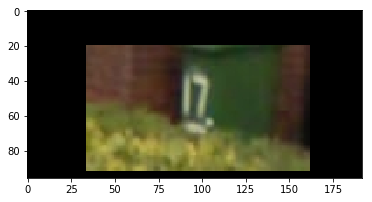

In [4]:
# Load an example image
example_image = dtype2uint8(mpimg.imread('/home/zhi/Downloads/SVHN/fixed_scale_test/786.png'))
print('The size of the image is {}.'.format(example_image.shape))
plt.imshow(example_image)

### 2.2.2. Calculate prediction maps

In [5]:
# Prediction
example_prediction = all_in_one_model.predict(np.expand_dims(np.float32(example_image)/127.5-1.0, axis=0))
print(example_prediction[0].shape)
print(example_prediction[1].shape)
print(example_prediction[2].shape)

(1, 65, 161, 10)
(1, 65, 161, 2)
(1, 65, 161, 2)


In [6]:
# Calculate the map
pad_size = 16
cls_map = np.lib.pad(np.argmax(np.squeeze(example_prediction[0]), axis=2), 
                     ((pad_size,pad_size-1),(pad_size,pad_size-1)), 'constant', constant_values=((0,0),(0,0)))
reg_map = np.lib.pad(np.squeeze(example_prediction[1]), 
                     ((pad_size,pad_size-1),(pad_size,pad_size-1),(0,0)), 'constant', constant_values=((0,0),(0,0),(0,0)))
#rp_map = np.lib.pad(np.argmax(np.squeeze(example_prediction[2]), axis=2), 
#                     ((pad_size,pad_size-1),(pad_size,pad_size-1)), 'constant', constant_values=((0,0),(0,0)))
rp_map = np.lib.pad(np.squeeze(example_prediction[2])[:,:,1]>0.99, 
                     ((pad_size,pad_size-1),(pad_size,pad_size-1)), 'constant', constant_values=((0,0),(0,0)))
print('The size of the cls_map is {}.'.format(cls_map.shape))
print('The size of the reg_map is {}.'.format(reg_map.shape))
print('The size of the rp_map is {}.'.format(rp_map.shape))

The size of the cls_map is (96, 192).
The size of the reg_map is (96, 192, 2).
The size of the rp_map is (96, 192).


### 2.2.3. Visualization of prediction maps

In [7]:
# calculate masked map
def masked_cls_map(cls_map,mask):
    color_map = np.uint8(np.zeros([cls_map.shape[0],cls_map.shape[1],3]))
    for k in range(10):
        color_map[:,:,0][np.bitwise_and(mask>0, cls_map==k)] = k*25
        color_map[:,:,1][np.bitwise_and(mask>0, cls_map==k)] = 255
        color_map[:,:,2][np.bitwise_and(mask>0, cls_map==k)] = 255
    color_map = cv2.cvtColor(color_map, cv2.COLOR_HSV2RGB)
    return color_map

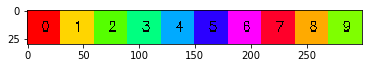

In [8]:
# draw a color bar to explain the colored map
def color_bar():
    color_bar = np.uint8(np.zeros([30,300,3]))
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(10):
        color_bar[:,i*30:(i+1)*30,0] = i*25
        color_bar[:,i*30:(i+1)*30,1] = 255
        color_bar[:,i*30:(i+1)*30,2] = 255
        cv2.putText(color_bar,'{}'.format(i),(i*30+12,18), font, 0.4,(0,0,0),1)
    color_bar = cv2.cvtColor(color_bar, cv2.COLOR_HSV2RGB)
    return color_bar
plt.imshow(color_bar())

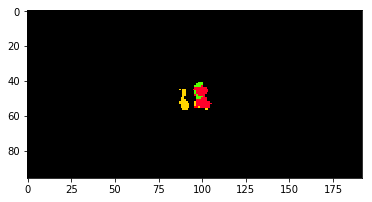

In [9]:
# Show the masked classification map
plt.imshow(masked_cls_map(cls_map,rp_map))

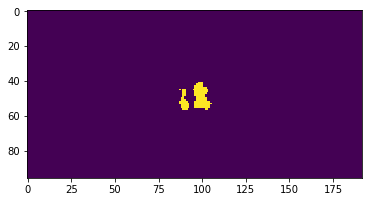

In [10]:
# Show the mask (the region proposal map)
plt.imshow(rp_map)

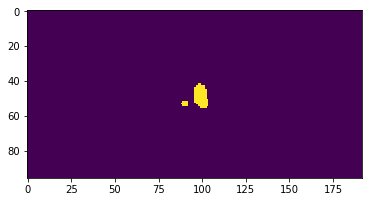

In [11]:
# Mophological operations on the mask
plt.imshow(cv2.medianBlur(np.uint8(rp_map), 7))

### 2.2.4. Modify the mask

In [12]:
# Modify the region proposal map using the regression map
# The result is a heatmap
def modify_rp_map(rp_map,reg_map,pad_size,std=2):
    mod_rp_map = np.zeros(rp_map.shape)
    for r in range(rp_map.shape[0]):
        for c in range(rp_map.shape[1]):
            if rp_map[r,c]:
                if abs(reg_map[r,c,0])<pad_size-1-std and abs(reg_map[r,c,1])<pad_size-1-std: # protection
                    # Enlarge, move, and accumulate the pixels on the region proposal map to a new location
                    mod_rp_map[r+np.int32(round(reg_map[r,c,1]))-std:r+np.int32(round(reg_map[r,c,1]))+std+1,
                               c+np.int32(round(reg_map[r,c,0]))-std:c+np.int32(round(reg_map[r,c,0]))+std+1] += 1
                    #mod_rp_map[r+int(reg_map[r,c,1]),c+int(reg_map[r,c,0])] += 1
    return mod_rp_map

In [13]:
mod_rp_map = modify_rp_map(rp_map,reg_map,pad_size=16,std=2)

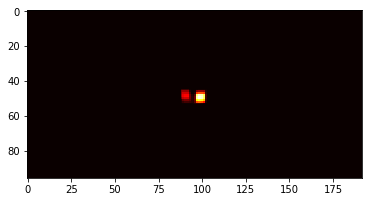

In [14]:
# Show the heatmap
plt.imshow(mod_rp_map, cmap='hot')

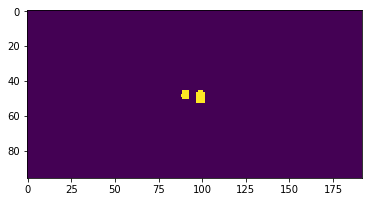

In [15]:
# Apply threshold to the heatmap to get the new mask
plt.imshow(mod_rp_map>20)

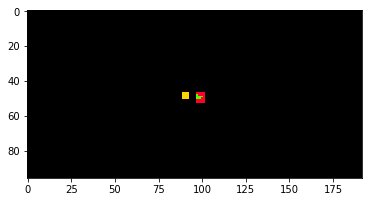

In [16]:
# Show the classification map under this new mask
plt.imshow(masked_cls_map(cls_map,mod_rp_map>25))

### 2.2.5. Isolated region analysis

In [17]:
# perform connected component analysis
labels = label(mod_rp_map>20)

In [18]:
def label_analysis(cls_map, labels):
    '''
    This function is designed to analysis the center as well as the class of each isolated regions in cls_map.
    Inputs:
        cls_map: the classification result
        labels: the labeled regions obtained by conected component analysis
    Outputs:
        position_class_list: A list stores the center as well as the class of each isolated regions
        (The first two comp. in each row of position_class_list represent the position of the center. The third comp. 
        is the class label.)
    '''
    position_class_list = np.zeros([labels[1],3])
    for label in range(1, labels[1]+1):
        # Find pixels with each label value
        nonzero = (labels[0] == label).nonzero()
        # Identify x and y values of those pixels
        position_class_list[label-1,0] = np.mean(nonzero[0])
        position_class_list[label-1,1] = np.mean(nonzero[1])
        # claculate the class
        position_class_list[label-1,2] = np.argmax(np.bincount(cls_map[nonzero].flatten()))
    # Return the image
    return position_class_list

In [19]:
position_class_list = label_analysis(cls_map, labels)
print(position_class_list)

[[ 48.04545455  90.27272727   1.        ]
 [ 49.18181818  99.           7.        ]]


### 2.2.6. Calculate the number

In [20]:
def calculate_number(position_class_list):
    '''
    This function is used to calculate the number from the position_class_list
    '''
    xplusy = position_class_list[:,0]+position_class_list[:,1]
    sorted_indexes = np.argsort(xplusy)
    sequence = position_class_list[:,2][sorted_indexes]
    number = 0
    for i in range(len(sequence)):
        number = number*10+sequence[i]
    
    return int(number)

In [21]:
calculate_number(position_class_list)

17

In [22]:
# Define a function to overlay the results
def overlay_result(image,position_class_list,dx=8,dy=16):
    overlay = np.copy(image)
    for i in range(len(position_class_list)):
        left = int(position_class_list[i,1]-dx)
        right = int(position_class_list[i,1]+dx)
        top = int(position_class_list[i,0]-dy)
        bottom = int(position_class_list[i,0]+dy)
        cv2.rectangle(overlay,(left,top),(right,bottom),(0,255,0),1)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(overlay,'{}'.format(int(position_class_list[i,2])),(left,top), font, 0.4,(0,255,0),1)
    cv2.putText(overlay,'The number is {}.'.format(calculate_number(position_class_list)),
                (0,image.shape[0]-1), font, 0.4,(0,255,0),1)
    return overlay

In [23]:
overlay = overlay_result(example_image,position_class_list,dx=8,dy=16)

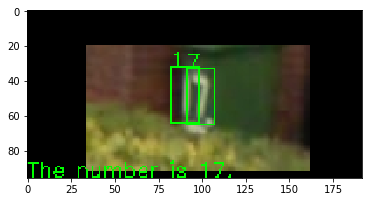

In [24]:
plt.imshow(overlay)

### 2.2.7. All in one

In [25]:
def pipeline(all_in_one_model, image_file, T_rp=0.99, std=2, T_hot=20, dx=8, dy=16, pad_size=16, show_details=False):
    image = dtype2uint8(mpimg.imread(image_file))
    prediction = all_in_one_model.predict(np.expand_dims(np.float32(image)/127.5-1.0, axis=0))
    cls_map = np.lib.pad(np.argmax(np.squeeze(prediction[0]), axis=2), 
                         ((pad_size,pad_size-1),(pad_size,pad_size-1)), 'constant', constant_values=((0,0),(0,0)))
    reg_map = np.lib.pad(np.squeeze(prediction[1]), 
                         ((pad_size,pad_size-1),(pad_size,pad_size-1),(0,0)), 'constant', constant_values=((0,0),(0,0),(0,0)))
    rp_map = np.lib.pad(np.squeeze(prediction[2])[:,:,1]>T_rp, 
                         ((pad_size,pad_size-1),(pad_size,pad_size-1)), 'constant', constant_values=((0,0),(0,0)))
    #rp_map = cv2.medianBlur(np.uint8(rp_map), 7)
    mod_rp_map = modify_rp_map(rp_map,reg_map,pad_size=pad_size,std=std)
    #mod_rp_map = rp_map.copy()
    labels = label(mod_rp_map>T_hot)
    #labels = label(mod_rp_map)
    if labels[1] == 0:
        return None,image
    position_class_list = label_analysis(cls_map, labels)
    number = calculate_number(position_class_list)
    overlay = overlay_result(image,position_class_list,dx=dx,dy=dy)
    
    if show_details:
        fig = plt.figure(figsize=(16,8))
        print('The size of the image is {}.'.format(example_image.shape))
        print('The size of the cls_map is {}.'.format(cls_map.shape))
        print('The size of the reg_map is {}.'.format(reg_map.shape))
        print('The size of the rp_map is {}.'.format(rp_map.shape))
        print('The position_class_list is')
        print('{}.'.format(position_class_list))

        fig.add_subplot(2,3,1)
        plt.title('image')
        plt.imshow(image)
        fig.add_subplot(2,3,2)
        plt.title('masked classification map')
        plt.imshow(masked_cls_map(cls_map,rp_map))
        fig.add_subplot(2,3,3)
        plt.title('hotmap')
        plt.imshow(mod_rp_map, cmap='hot')
        fig.add_subplot(2,3,4)
        plt.title('improved masked classification map')
        plt.imshow(masked_cls_map(cls_map,mod_rp_map>T_hot))
        fig.add_subplot(2,3,5)
        plt.title('result')
        plt.imshow(overlay)
        fig.tight_layout()
        fig.add_subplot(2,3,6)
        plt.title('color bar')
        plt.imshow(color_bar())
        
    
    return number, overlay

## 2.3. Test the pipeline

The size of the image is (96, 192, 3).
The size of the cls_map is (96, 192).
The size of the reg_map is (96, 192, 2).
The size of the rp_map is (96, 192).
The position_class_list is
[[ 48.04545455  90.27272727   1.        ]
 [ 49.18181818  99.           7.        ]].


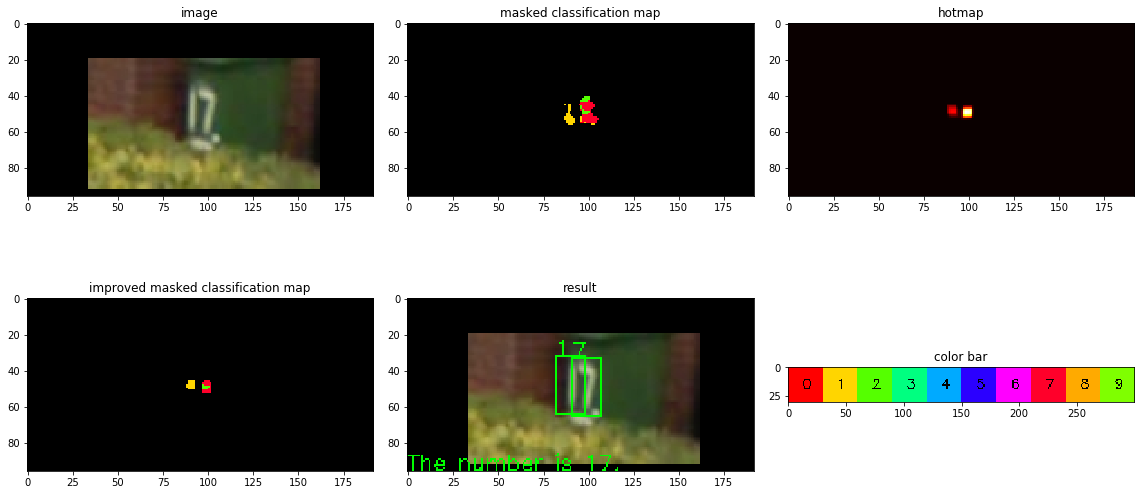

In [26]:
image_file = '/home/zhi/Downloads/SVHN/fixed_scale_test/786.png'# 786
number, overlay = pipeline(all_in_one_model, 
                           image_file, 
                           T_rp=0.99, std=2, T_hot=20, dx=8, dy=16, pad_size=16, show_details=True)

## 2.4. Evaluate overall performance

In [27]:
test_image_folder = '/home/zhi/Downloads/SVHN/fixed_scale_test/'
truth_file = h5py.File("/home/zhi/Downloads/SVHN/fixed_scale_test/numbers.mat", "r")
wrongly_classified_folder = '/home/zhi/Downloads/SVHN/wrongly_classified/'
correctly_classified_folder = '/home/zhi/Downloads/SVHN/correctly_classified/'
for i in range(len(truth_file['numbers'])):
#for i in range(100):
    number, overlay = pipeline(all_in_one_model, 
                               test_image_folder+'{}.png'.format(i+1), 
                               T_rp=0.99, std=2, T_hot=20, dx=8, dy=16, pad_size=16, show_details=False)
    if number != truth_file['numbers'][i]:
        mpimg.imsave(wrongly_classified_folder+'{}.png'.format(i+1),overlay)
    else:
        mpimg.imsave(correctly_classified_folder+'{}.png'.format(i+1),overlay)

/home/zhi/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
